## Code for simulating theta cycling of place cells in a T-maze environment

In [1]:
import numpy as np
import brainpy.math as bm
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

import os
os.chdir("..")

from sweep.network_models import PCNet, PCParams
from sweep import plotting

from ratinabox.Environment import Environment
from ratinabox.Agent import Agent
from tqdm import tqdm

bm.set_dt(1.)

#auto reload
%load_ext autoreload
%autoreload 2

np.random.seed(10) #for reproducibility


In [2]:
def simulate_pcnet(net: PCNet, positions, velocity_gains, theta_strength=0, theta_cycle_len=100):
    """Simulate DCNet over a trajectory of directions and velocity gains."""
    def step(i, position, velocity_gain):
        # theta oscillation phase
        t = i * bm.dt
        theta_phase = bm.mod(t, theta_cycle_len) / theta_cycle_len
        theta_phase = theta_phase * 2 * np.pi - np.pi

        # theta modulation
        theta_modulation = 1 + theta_strength * velocity_gain * bm.cos(theta_phase)

        # update network
        net.step_run(i, position, theta_modulation)

        return net.center, net.r, theta_phase, theta_modulation

    return bm.for_loop(
        step,
        (bm.arange(len(positions)), positions, velocity_gains),
        progress_bar=True
    )


### 1. First let's build a simple linear track environment

In [3]:
# 1. define the linear track and place cell density
L_track = 1.5   # length of the linear track (m)
dx = 0.01        # spatial discretization (m), this is also the distance between two adjacent place cell fields
num_nodes = int(L_track / dx) + 1   # number of nodes, i.e., number of place cells

# 2. Build the graph
graph = nx.Graph()
graph.graph['dx'] = dx
for i in range(num_nodes - 1):
    graph.add_edge(i, i + 1, weight=dx)


/home/zilong/anaconda3/envs/anticipative_track_gpu/lib/python3.9/site-packages/ratinabox/utils.py:891: UserWarning: Found 1 unexpected params key(s) while initializing Agent object: 'rotation_velocity_std'.
If you intended to set this parameter, ignore this message. To see all default parameters for this class call Agent.get_all_default_params().
  warnings.warn(
/home/zilong/anaconda3/envs/anticipative_track_gpu/lib/python3.9/site-packages/ratinabox/Agent.py:145: UserWarning: Warning: You have solid 1D boundary conditions and non-zero speed mean.
  warnings.warn(
  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [00:00<00:00, 14484.06it/s]
2025-10-07 14:17:23.937711: W external/xla/xla/service/gpu/nvptx_compiler.cc:763] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


    • To AUTOMATICALLY save all plots (recommended), set  `ratinabox.autosave_plots = True`
    • To MANUALLY save plots, call                        `ratinabox.utils.save_figure(figure_object, save_title).
      This warning will not be shown again
HINT: You can stylize plots to make them look like repo/paper by calling `ratinabox.stylize_plots()`
      This hint will not be shown again


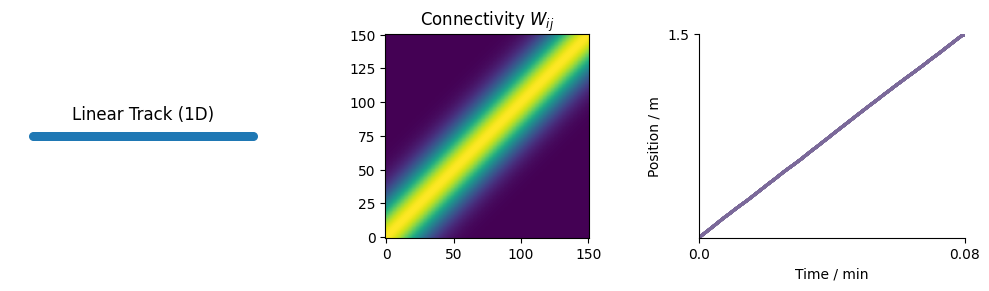

In [4]:
#We will create a circular environment with a circular hole in the center, so that head direction keeps changing. Cleaver and simple, right!
Env = Environment(params={"dimensionality": "1D", "scale": L_track})
#dt is 1 ms
Ag = Agent(Env,params={'dt':0.001, 'speed_mean':0.3, 'speed_std':0.01, 'speed_coherence_time':0.08,
                      'rotation_velocity_std':180*np.pi/180, 'rotational_velocity_coherence_time':0.01})

simulate_time = 5 #seconds
Ag.pos = np.array([0.0]) #set initial position
for i in tqdm(range(int( simulate_time / Ag.dt))): 
    Ag.update()
    
positions = np.array(Ag.history["pos"]).squeeze()
#embedding positions into index 
animal_pos_node_index = np.clip(np.round(positions / dx).astype(int), 0, num_nodes - 1)

velocity = np.array(Ag.history["vel"]).squeeze()
velocity_gains = np.abs(velocity)/np.percentile(np.abs(velocity), 99)    


fig, axs = plt.subplots(1,3,figsize=(10,3),dpi=100)

#plot the graph
pos = {i: (i * dx, 0) for i in range(num_nodes)}
nx.draw(graph, pos, node_size=30, ax=axs[0])
axs[0].set_aspect('equal', 'box')
axs[0].set_title("Linear Track (1D)")

# visualize the connectivity
synaptic_connection  = PCNet(graph, params=PCParams()).conn_mat
im = axs[1].imshow(synaptic_connection, cmap='viridis', origin='lower')
axs[1].set_title("Connectivity $W_{ij}$")

#plot the trajectory
Ag.plot_trajectory(fig=fig, ax=axs[2], framerate=1000)

plt.tight_layout()


  0%|          | 0/5000 [00:00<?, ?it/s]

/tmp/ipykernel_2570124/1777404324.py:51: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


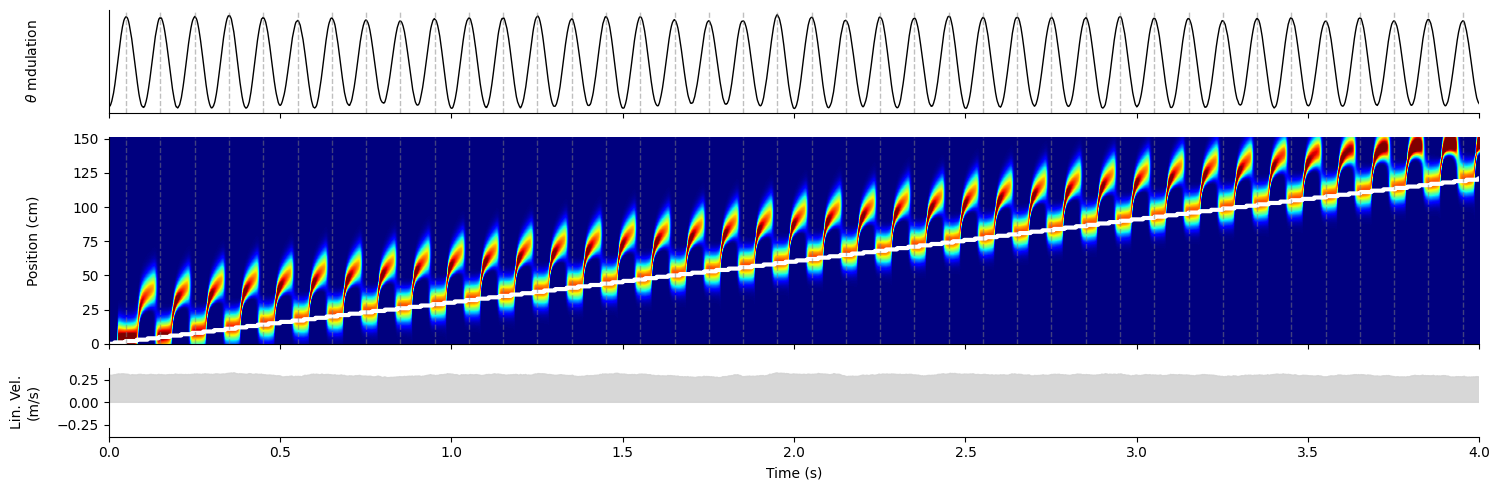

In [26]:
# build the network
params = PCParams(adaptation_strength=10, a=0.1)
pc_net = PCNet(graph, params=params)   

# simulate the DC network
internal_position, net_activity, theta_phase, theta_modulation = simulate_pcnet(
    pc_net, animal_pos_node_index, velocity_gains, theta_strength=10, theta_cycle_len=100
)

internal_direction = np.array(internal_position)
net_activity = np.array(net_activity)
theta_phase = np.array(theta_phase)
theta_modulation = np.array(theta_modulation)

time_steps = np.array(Ag.history["t"])

fig, axes = plt.subplots(
    3,
    1,
    figsize=(15, 5),
    sharex=True,
    constrained_layout=True,
    gridspec_kw={"height_ratios": [1.5, 3, 1]},
    dpi=100,
)

ax = axes[0]
#set theta_modulation outliear as median
theta_modulation[theta_modulation > np.median(theta_modulation) + 10 * np.std(theta_modulation)] = np.median(theta_modulation)
theta_modulation[theta_modulation < np.median(theta_modulation) - 10 * np.std(theta_modulation)] = np.median(theta_modulation)
ax = plotting.plot_theta_modulation(ax, time_steps, theta_phase, theta_modulation, add_lines=True, atol=5e-2)

ax = axes[1]
ax = plotting.plot_population_activity_linear(ax, time_steps, theta_phase, net_activity, animal_pos_node_index, add_lines=True, atol=5e-2)

ax = axes[2]
ax = plotting.plot_linear_velocity(ax, time_steps, velocity)


for ax in axes:
    sns.despine(ax=ax)
    #align ylabels vertically
    ax.yaxis.set_label_coords(-0.05, 0.5)  # Shift labels left (adjust as needed)
    #labelsize as 14
    ax.tick_params(axis='both', which='major', labelsize=10)
    #labelsize as 14
    ax.yaxis.label.set_size(10)
    ax.xaxis.label.set_size(10)
    ax.set_xlim(0,4)

plt.tight_layout()


### 2. Let's simulate the T-maze environment

total number of nodes: 351
total numbe of edges: 350


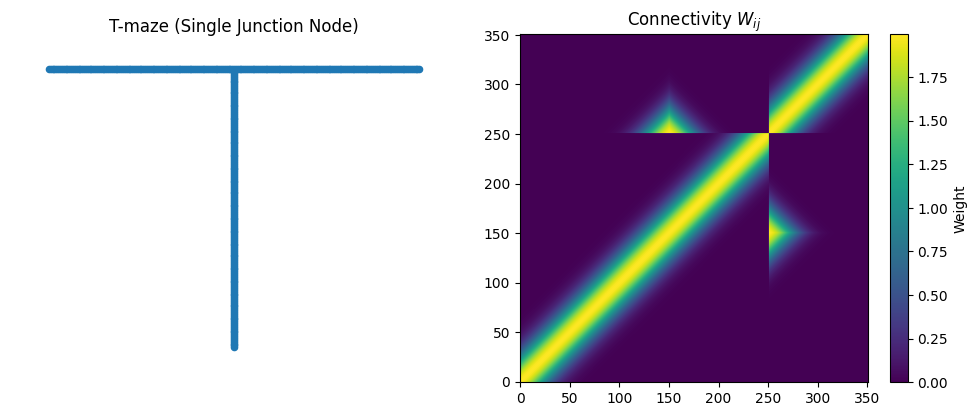

In [38]:
# 1. define the T-maze and place cell density
L_CJ = 1.5   # center arm length (m)
L_JL = 1.0   # left arm length (m)
L_JR = 1.0   # right arm length (m)
dx = 0.01     # spatial discretization (m), this is also the distance between two adjacent place cell fields

nC = int(L_CJ / dx)
nL = int(L_JL / dx)
nR = int(L_JR / dx)

# 2. Build the graph
graph = nx.Graph()
graph.graph['dx'] = dx

# define the edge on central arm
for i in range(nC - 1):
    graph.add_edge(('C', i), ('C', i + 1), weight=dx)
# add the edge to junction J
graph.add_edge(('C', nC - 1), 'J', weight=dx)

# define the edge on left arm
for i in range(nL - 1):
    graph.add_edge(('L', i), ('L', i + 1), weight=dx)
# add the edge to junction J
graph.add_edge('J', ('L', 0), weight=dx)

#define the edge on right arm
for i in range(nR - 1):
    graph.add_edge(('R', i), ('R', i + 1), weight=dx)
#add the edge to junction J
graph.add_edge('J', ('R', 0), weight=dx)

nodes = list(graph.nodes)
N = len(nodes)
print(f"total number of nodes: {N}")
print(f"total numbe of edges: {len(graph.edges)}")

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

#plot the graph
pos = {}
for i in range(nC):
    pos[('C', i)] = (0, i * dx)
pos['J'] = (0, L_CJ)
for i in range(nL):
    pos[('L', i)] = (- (i + 1) * dx, L_CJ)
for i in range(nR):
    pos[('R', i)] = ((i + 1) * dx, L_CJ)

nx.draw(graph, pos, node_size=20, ax=ax[0])
ax[0].set_aspect('equal', 'box')
ax[0].set_title("T-maze (Single Junction Node)")

#visualize the connectivity
synaptic_connection  = PCNet(graph, params=PCParams()).conn_mat
im = ax[1].imshow(synaptic_connection, cmap='viridis', origin='lower')
ax[1].set_title("Connectivity $W_{ij}$")
fig.colorbar(im, ax=ax[1], label="Weight")
plt.tight_layout()


In [37]:
# ======================================================
# Geometric coordinates for visualisation / spatial embedding
# ======================================================
pos = {}

for n in nodes:
    if isinstance(n, tuple):
        seg, i = n
        if seg == 'C':  # central arm (vertical)
            pos[n] = (0.0, i * dx)
        elif seg == 'L':  # left arm (horizontal, leftwards)
            pos[n] = (-(i + 1) * dx, L_CJ)
        elif seg == 'R':  # right arm (horizontal, rightwards)
            pos[n] = ((i + 1) * dx, L_CJ)
    elif n == 'J':  # single junction node
        pos[n] = (0.0, L_CJ)

# Convert all node positions into an array following the same order as 'nodes'
x_bins = np.array([pos[n] for n in nodes])  # shape (N, 2)

print("x_bins shape:", x_bins.shape)
print(x_bins)

x_bins shape: (351, 2)
[[ 0.    0.  ]
 [ 0.    0.01]
 [ 0.    0.02]
 [ 0.    0.03]
 [ 0.    0.04]
 [ 0.    0.05]
 [ 0.    0.06]
 [ 0.    0.07]
 [ 0.    0.08]
 [ 0.    0.09]
 [ 0.    0.1 ]
 [ 0.    0.11]
 [ 0.    0.12]
 [ 0.    0.13]
 [ 0.    0.14]
 [ 0.    0.15]
 [ 0.    0.16]
 [ 0.    0.17]
 [ 0.    0.18]
 [ 0.    0.19]
 [ 0.    0.2 ]
 [ 0.    0.21]
 [ 0.    0.22]
 [ 0.    0.23]
 [ 0.    0.24]
 [ 0.    0.25]
 [ 0.    0.26]
 [ 0.    0.27]
 [ 0.    0.28]
 [ 0.    0.29]
 [ 0.    0.3 ]
 [ 0.    0.31]
 [ 0.    0.32]
 [ 0.    0.33]
 [ 0.    0.34]
 [ 0.    0.35]
 [ 0.    0.36]
 [ 0.    0.37]
 [ 0.    0.38]
 [ 0.    0.39]
 [ 0.    0.4 ]
 [ 0.    0.41]
 [ 0.    0.42]
 [ 0.    0.43]
 [ 0.    0.44]
 [ 0.    0.45]
 [ 0.    0.46]
 [ 0.    0.47]
 [ 0.    0.48]
 [ 0.    0.49]
 [ 0.    0.5 ]
 [ 0.    0.51]
 [ 0.    0.52]
 [ 0.    0.53]
 [ 0.    0.54]
 [ 0.    0.55]
 [ 0.    0.56]
 [ 0.    0.57]
 [ 0.    0.58]
 [ 0.    0.59]
 [ 0.    0.6 ]
 [ 0.    0.61]
 [ 0.    0.62]
 [ 0.    0.63]
 [ 0.    0.64]
 [